In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate

### my library

import plots
import utils
import images
import distances
import transforms
import alignments

In [2]:
def generate_projections(V, angles, axis=0):
    """"Function to generate 2D projection images"""
    
    projections = []
    for angle in angles:
        rotated_V = rotate(V, angle, axes=(0, 2), reshape=False, mode='nearest')
        projection = np.sum(rotated_V, axis=axis)  # Sum along the chosen axis
        projections.append(projection)
    return np.array(projections)


def generate_centered_gaussian_3d(L, sigma=10):
    """Generate an LxL image with a centered 2D Gaussian distribution"""
    p = np.linspace(-L//2, L//2, L)
    x, y, z = np.meshgrid(p, p, p)
    gaussian = np.exp(-(x**2 + y**2 + z**2) / (2 * sigma**2))
    gaussian = gaussian / np.sum(gaussian) # Normalize to sum = 1
    return gaussian


def random_points_in_sphere_voxelized(L, D, n):
    """Generate `n` random points uniformly distributed inside a sphere of given `radius`"""
    
    V = np.zeros((L, L, L))
    radius = D / L
    
    phi = np.random.uniform(0, 2 * np.pi, n)   # Azimuthal angle
    costheta = np.random.uniform(-1, 1, n)     # Cosine of polar angle
    u = np.random.uniform(0, 1, n)             # Random variable for radius

    theta = np.arccos(costheta)                # Convert to polar angle
    r = radius * (u ** (1/3))                  # Cube root to maintain uniformity

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    points = np.column_stack((x, y, z))
    voxels = (np.round((points * L//2)) + L//2).astype('int')  # nearest neighbor interpolation
    V[tuple(voxels.T)] = 1
    
    return V

In [3]:
np.random.seed(0)

L = 128
D = L * (3/4)
n_points = 100
sigma = 0.1

Vol = random_points_in_sphere_voxelized(L, D, n_points)
G = generate_centered_gaussian_3d(L, sigma)
G_hat = np.fft.fftshift(np.fft.fftn(G))
V_hat = np.fft.fftshift(np.fft.fftn(Vol))
Vol = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(G_hat * V_hat))).real

In [4]:
# Define projection angles
a_max = 90
n_projections = 90
proj_angles = np.linspace(0, a_max, n_projections)

# Generate projections
projections = generate_projections(Vol, proj_angles)
imgs = images.Image(projections).preprocess_images()

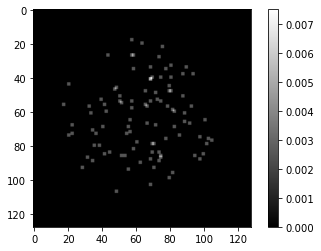

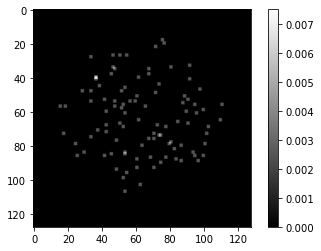

In [5]:
plt.imshow(imgs[0], cmap='gray')
# plt.axis('off')
plt.colorbar()
plt.show()
plt.imshow(imgs[-1], cmap='gray')
# plt.axis('off')
plt.colorbar()
plt.show()

In [6]:
N, ny, nx = imgs.shape
n_points = ny
angles = np.linspace(0, 360, ny, endpoint=False)
n_theta = len(angles)

refs = np.array([imgs[0], imgs[0]])
imgs = imgs[:]  # or skip first image


### sliced Wasserstein (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_sw_nrf = np.array([distances.sliced_distance(U[0], V[idx]) for idx in range(N)]) 
print('SW nrf runtime: ', time.time() - t)


### sliced Wasserstein distance (signed)
t = time.time()
Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
dists_sw_sgn = np.array([distances.signed_sliced_distance(Up[0], Vp[idx], Un[0], Vn[idx]) for idx in range(N)])
print('SW sgn runtime: ', time.time() - t)


### sliced Wasserstein distance (positive, negative)
t = time.time()
Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
dists_sw_pos = np.array([distances.sliced_distance(Up[0], Vp[idx]) for idx in range(N)])
dists_sw_neg = np.array([distances.sliced_distance(Un[0], Vn[idx]) for idx in range(N)])
print('SW pos runtime: ', time.time() - t)


### sliced Cramer (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
dists_sc_nrf = np.array([distances.sliced_distance(U[0], V[idx]) for idx in range(N)])
print('SC nrf runtime: ', time.time() - t)


## Brute force rotations
t = time.time()
dists_bfr = np.array([distances.l2_distance(refs[0], imgs[idx]) for idx in range(N)])
print('    BF runtime: ', time.time() - t)


# ### Wasserstein 2
# t = time.time()
# M = distances.compute_transport_matrix(imgs[0], metric='sqeuclidean')
# M = M / np.amax(M)
# dists_w2 = np.array([distances.wasserstein_distance(refs[0], imgs[idx], M) for idx in range(N)])
# print('    W2 runtime: ', time.time() - t)

SW nrf runtime:  0.45993876457214355
SW sgn runtime:  0.5773046016693115
SW pos runtime:  0.5664513111114502
SC nrf runtime:  0.344165563583374
    BF runtime:  0.002366304397583008


In [7]:
p = 2

upper_bound_l2 = np.ones(n_projections) * np.sqrt(2 * np.sum(imgs[0]**2))

upper_bound_sliced_wasserstein = (1 - ((2*p) / ((p+1)*np.pi)))**(1/p) * np.deg2rad(proj_angles) / np.sqrt(L)

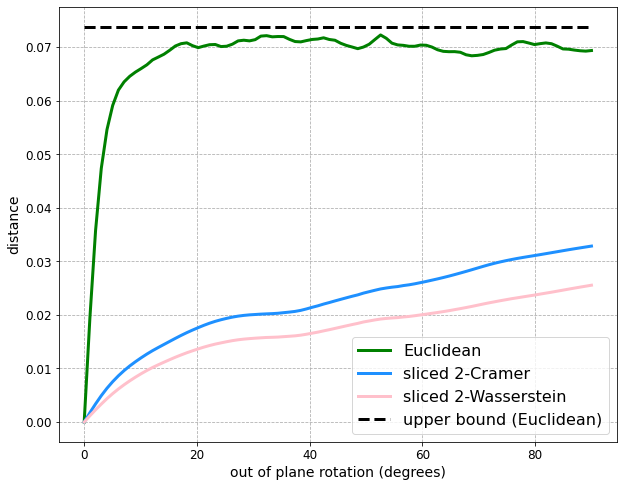

In [11]:
plt.figure(figsize=(10,8))

colors = {'bf': 'green', 'wemd': 'salmon', 'sw_sgn': 'rebeccapurple', 
          'sw_max': 'firebrick', 'sc_nrf': 'dodgerblue', 'sw_nrf': 'pink', 'w2': 'orange', 'sw_pos': 'gray', 'sw_neg': 'red'}

plt.plot(proj_angles, dists_bfr[:], color=colors['bf'], linewidth=3, label='Euclidean')
# plt.plot(proj_angles, dists_w2[:], color=colors['w2'], linewidth=3, label='2-Wasserstein')
plt.plot(proj_angles, dists_sc_nrf[:], color=colors['sc_nrf'], linewidth=3, label='sliced 2-Cramer')
plt.plot(proj_angles, dists_sw_nrf[:], color=colors['sw_nrf'], linewidth=3, label='sliced 2-Wasserstein')
# plt.plot(proj_angles, dists_sw_sgn[:], color=colors['sw_sgn'], linewidth=3, label='sliced 2-Wasserstein (signed)')
# plt.plot(proj_angles, dists_sw_pos[:], color=colors['sw_pos'], linewidth=3, label='sliced 2-Wasserstein (positive)')
# plt.plot(proj_angles, dists_sw_neg[:], color=colors['sw_neg'], linewidth=3, label='sliced 2-Wasserstein (negative)')

plt.plot(proj_angles, upper_bound_l2, color='black', linestyle='--', linewidth=3, label='upper bound (Euclidean)')

# plt.plot(proj_angles, upper_bound_sliced_wasserstein, color='black', linestyle='--', linewidth=3, label='upper bound (sliced Wasserstein)')


plt.xlabel('out of plane rotation (degrees)')
plt.ylabel('distance')
plt.grid(which='major', linestyle='--')
plt.legend()
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=16)
plt.show()

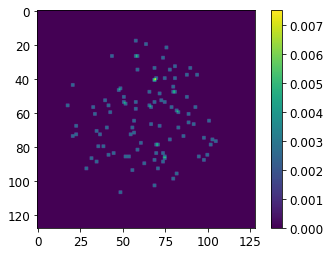

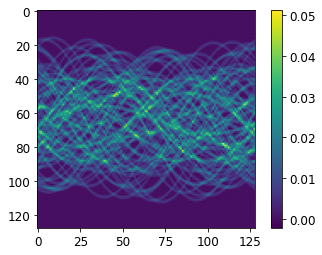

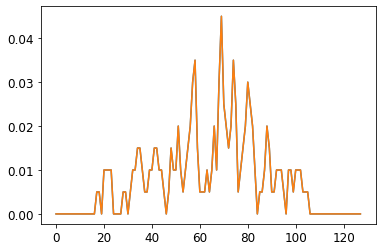

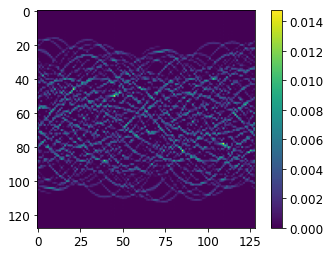

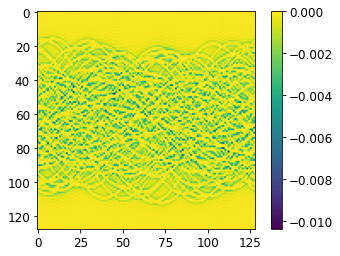

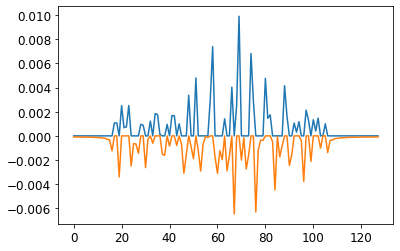

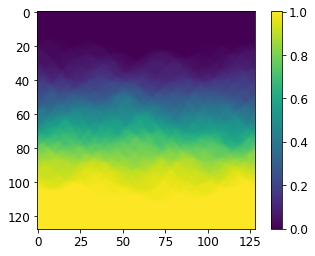

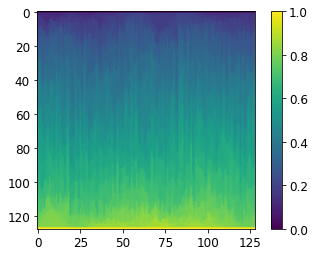

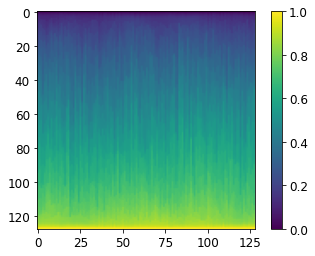

In [9]:
z = transforms.Transform(imgs, apply_ramp=False).radon_transform()
z_ramp = transforms.Transform(imgs, apply_ramp=True).radon_transform()
z_p = np.where(z_ramp[0] > 0, z_ramp[0], 0)
z_n = np.where(z_ramp[0] < 0, z_ramp[0], 0)

plt.imshow(imgs[0])
plt.colorbar()
plt.show()

plt.imshow(z[0])
plt.colorbar()
plt.show()

plt.plot(np.sum(imgs[0], axis=0))
plt.plot(z[0, :, 0])
plt.show()

plt.imshow(z_p)
plt.colorbar()
plt.show()

plt.imshow(z_n)
plt.colorbar()
plt.show()

plt.plot(z_p[:, 0])
plt.plot(z_n[:, 0])
plt.show()

plt.imshow(U[0])
plt.colorbar()
plt.show()


plt.imshow(Up[0])
plt.colorbar()
plt.show()

plt.imshow(Un[0])
plt.colorbar()
plt.show()

In [12]:
# # Save the array as an MRC file
# import mrcfile
# with mrcfile.new('Output/sphere_em_sparse.mrc', overwrite=True) as mrc:
#     mrc.set_data(Vol.astype('float32'))